## Predicting Airline Satisfaction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.graph_objs as go

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### import data

In [2]:
df = pd.read_csv('../data/train.csv')
df.shape

(98326, 25)

## Exploratory Data Analysis

In [3]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460.0,3.0,4.0,...,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235.0,3.0,2.0,...,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142.0,2.0,2.0,...,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562.0,2.0,5.0,...,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214.0,3.0,3.0,...,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,satisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98326 entries, 0 to 98325
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         98326 non-null  int64  
 1   id                                 98326 non-null  int64  
 2   Gender                             98326 non-null  object 
 3   Customer Type                      98326 non-null  object 
 4   Age                                98326 non-null  int64  
 5   Type of Travel                     98326 non-null  object 
 6   Class                              98325 non-null  object 
 7   Flight Distance                    98325 non-null  float64
 8   Inflight wifi service              98325 non-null  float64
 9   Departure/Arrival time convenient  98325 non-null  float64
 10  Ease of Online booking             98325 non-null  float64
 11  Gate location                      98325 non-null  flo

In [5]:
df = df.drop(df.iloc[:,[0, 1]], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98326 entries, 0 to 98325
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             98326 non-null  object 
 1   Customer Type                      98326 non-null  object 
 2   Age                                98326 non-null  int64  
 3   Type of Travel                     98326 non-null  object 
 4   Class                              98325 non-null  object 
 5   Flight Distance                    98325 non-null  float64
 6   Inflight wifi service              98325 non-null  float64
 7   Departure/Arrival time convenient  98325 non-null  float64
 8   Ease of Online booking             98325 non-null  float64
 9   Gate location                      98325 non-null  float64
 10  Food and drink                     98325 non-null  float64
 11  Online boarding                    98325 non-null  flo

In [6]:
df = df[df['Type of Travel'] != 'Business']

In [7]:
# target variable: satisfaction
print(df[['satisfaction']].value_counts())

satisfaction           
neutral or dissatisfied    55714
satisfied                  42611
dtype: int64


In [8]:
categorical_indexes = [0, 1, 3, 4] + list(range(6, 20))
df.iloc[:,categorical_indexes] = df.iloc[:,categorical_indexes].astype('category')

In [9]:
# continuous variables
df.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,98325.000000,98325.000000,98325.000000,98029.000000
mean,39.378571,1189.407353,14.827907,15.190790
std,15.110796,996.605081,38.252575,38.726291
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1742.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


In [10]:
# include categorical variables
df.describe(include = ['category'])

,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
count,98325,98325,98325,98325,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0,98325.0
unique,2,2,2,3,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,6.0,6.0
top,Female,Loyal Customer,Business travel,Business,2.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
freq,49908,80318,67826,46995,24481.0,24196.0,23146.0,27053.0,23086.0,29144.0,30093.0,27839.0,29178.0,27235.0,35334.0,27527.0,35887.0,25749.0


#### Feature Ralationships

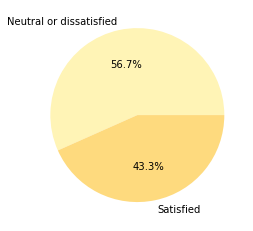

In [11]:
plt.pie(df.satisfaction.value_counts(), labels = ["Neutral or dissatisfied", "Satisfied"], colors = sns.color_palette("YlOrBr"), autopct = '%1.1f%%')
pass

In [12]:
corr_mat = df.corr()
corr_mat

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,0.098708,-0.010127,-0.012232
Flight Distance,0.098708,1.000000,0.002349,-0.002115
Departure Delay in Minutes,-0.010127,0.002349,1.000000,0.965670
Arrival Delay in Minutes,-0.012232,-0.002115,0.965670,1.000000


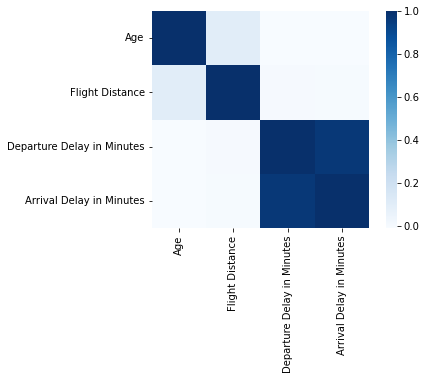

In [13]:
sns.heatmap(corr_mat, square = True, cmap = 'Blues')
pass

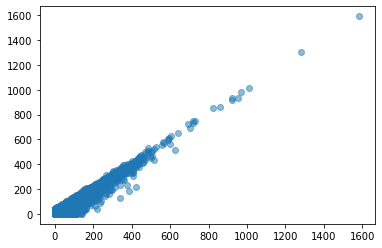

In [14]:
plt.scatter(df['Arrival Delay in Minutes'], df['Departure Delay in Minutes'], alpha = 0.5)
pass

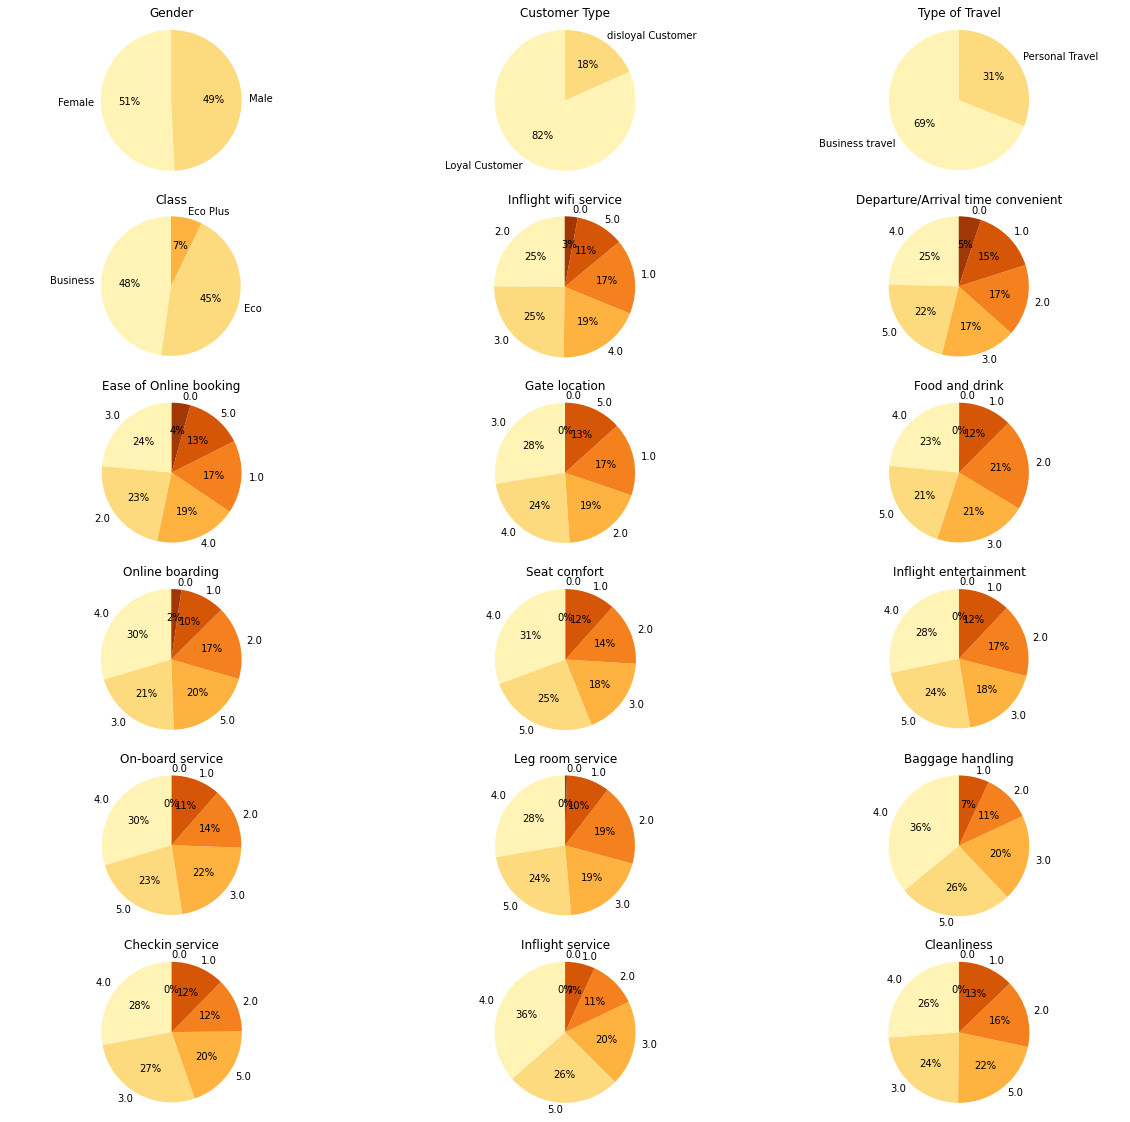

In [15]:
categ = df.iloc[:,categorical_indexes]
fig, axes = plt.subplots(6, 3, figsize = (20, 20))
for i, col in enumerate(categ):
    column_values = df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

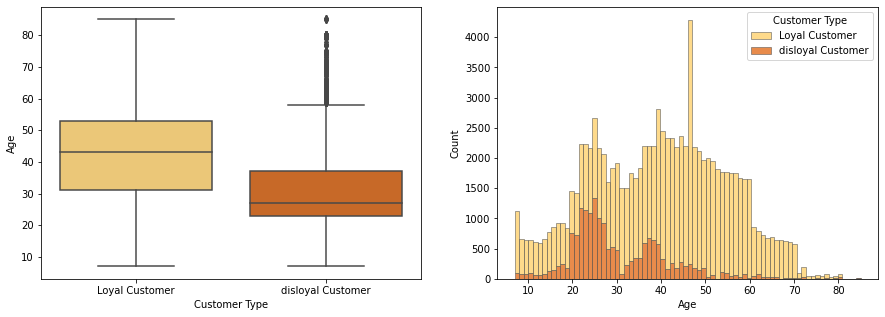

In [16]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Customer Type", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Age", hue = "Customer Type", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

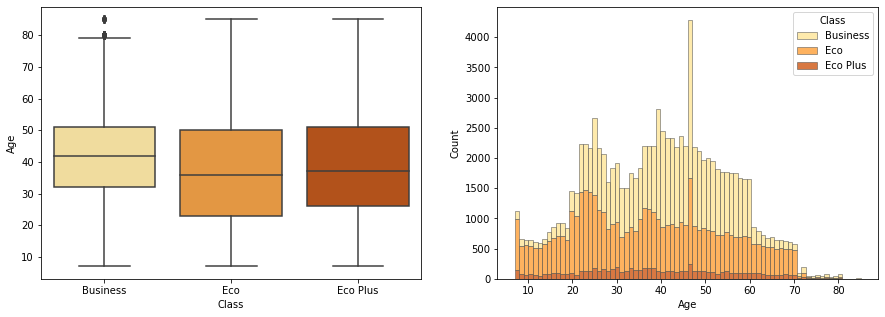

In [17]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Age", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

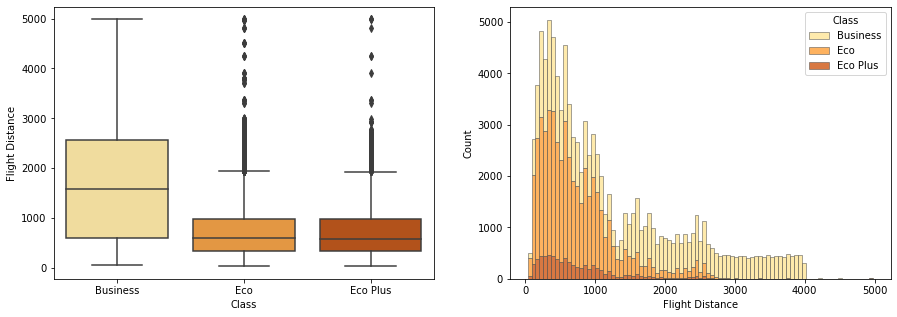

In [18]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Flight Distance", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

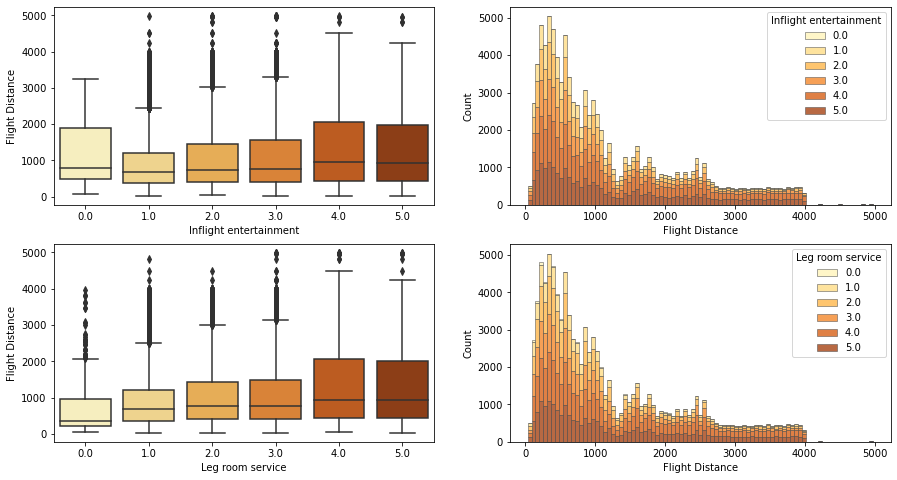

In [19]:
f, ax = plt.subplots(2, 2, figsize = (15,8))
sns.boxplot(x = "Inflight entertainment", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0, 0])
sns.histplot(df, x = "Flight Distance", hue = "Inflight entertainment", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[0, 1])
sns.boxplot(x = "Leg room service", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[1, 0])
sns.histplot(df, x = "Flight Distance", hue = "Leg room service", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1, 1])
pass

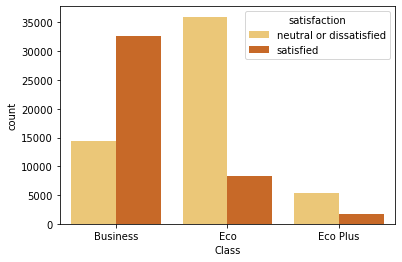

In [20]:
sns.countplot(x = 'Class', hue = 'satisfaction', palette = "YlOrBr", data = df)
plt.show()

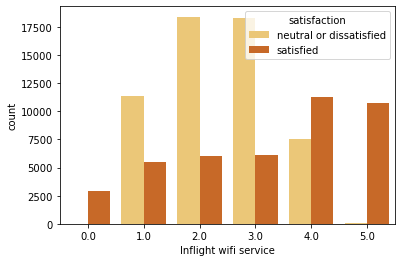

In [21]:
sns.countplot(x = 'Inflight wifi service', hue = 'satisfaction', palette = "YlOrBr", data = df)
plt.show()

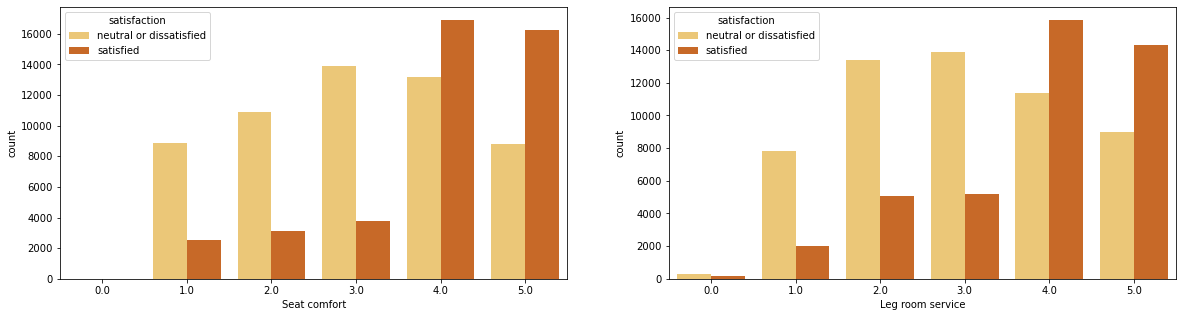

In [22]:
f, ax = plt.subplots(1, 2, figsize = (20,5))
sns.countplot(x = 'Seat comfort', hue = 'satisfaction', palette = "YlOrBr", data = df,ax = ax[0])
sns.countplot(x = 'Leg room service', hue = 'satisfaction', palette = "YlOrBr", data = df, ax = ax[1])
plt.show()

### Data Cleaning
- drop all NAs
- in a future iteration, we might improve performance by imputing rather than dropping

In [23]:
df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             296
satisfaction                           0
dtype: int64

In [24]:
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(axis = 0), inplace = True)

In [25]:
df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [26]:
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'category']
numerical_columns.remove('satisfaction')
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'category']
data_describe = df.describe(include = ['category'])

In [27]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Gender', 'Customer Type', 'Type of Travel'] ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']


In [28]:
for col in binary_columns:
    print(col, ': ', end = '')
    for uniq in df[col].unique():
        if uniq == df[col].unique()[-1]:
            print(uniq, end = '.')
        else:
            print(uniq, end = ', ')
    print()

Gender : Male, Female.
Customer Type : Loyal Customer, disloyal Customer.
Type of Travel : Personal Travel, Business travel.


In [29]:
for col in binary_columns:
    df[col] = df[col].astype('object')
    k = 0
    for uniq in df[col].unique():
        df.at[df[col] == uniq, col] = k
        k +=1 
for col in binary_columns:
    print(df[col].describe(), end = '\n\n')

count     98325
unique        2
top           1
freq      49908
Name: Gender, dtype: int64

count     98325
unique        2
top           0
freq      80318
Name: Customer Type, dtype: int64

count     98325
unique        2
top           1
freq      67826
Name: Type of Travel, dtype: int64



In [30]:
data_nonbinary = pd.get_dummies(df[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Class_Business', 'Class_Eco', 'Class_Eco Plus',
       'Inflight wifi service_0.0', 'Inflight wifi service_1.0',
       'Inflight wifi service_2.0', 'Inflight wifi service_3.0',
       'Inflight wifi service_4.0', 'Inflight wifi service_5.0',
       'Departure/Arrival time convenient_0.0',
       'Departure/Arrival time convenient_1.0',
       'Departure/Arrival time convenient_2.0',
       'Departure/Arrival time convenient_3.0',
       'Departure/Arrival time convenient_4.0',
       'Departure/Arrival time convenient_5.0', 'Ease of Online booking_0.0',
       'Ease of Online booking_1.0', 'Ease of Online booking_2.0',
       'Ease of Online booking_3.0', 'Ease of Online booking_4.0',
       'Ease of Online booking_5.0', 'Gate location_0.0', 'Gate location_1.0',
       'Gate location_2.0', 'Gate location_3.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_0.0', 'Food and drink_1.0',
       'Food and drink_2.0', 'Food and drink_3.0', 'Food and drink_4.0',
   

#### Normalize

In [31]:
data_numerical = df[numerical_columns]
data_numerical.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,98325.000000,98325.000000,98325.000000,98325.00000
mean,39.378571,1189.407353,14.827907,15.14506
std,15.110796,996.605081,38.252575,38.67691
min,7.000000,31.000000,0.000000,0.00000
25%,27.000000,414.000000,0.000000,0.00000
50%,40.000000,843.000000,0.000000,0.00000
75%,51.000000,1742.000000,12.000000,13.00000
max,85.000000,4983.000000,1592.000000,1584.00000


In [32]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [33]:
data_numerical.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,9.832500e+04,9.832500e+04,9.832500e+04,9.832500e+04
mean,-2.104664e-16,1.144492e-16,1.871656e-17,-5.736011e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.142744e+00,-1.162353e+00,-3.876316e-01,-3.915788e-01
25%,-8.191872e-01,-7.780488e-01,-3.876316e-01,-3.915788e-01
50%,4.112483e-02,-3.475874e-01,-3.876316e-01,-3.915788e-01
75%,7.690812e-01,5.544750e-01,-7.392724e-02,-5.546099e-02
max,3.019128e+00,3.806515e+00,4.123048e+01,4.056309e+01


In [34]:
df['satisfaction']

0        neutral or dissatisfied
1        neutral or dissatisfied
2                      satisfied
3        neutral or dissatisfied
4                      satisfied
                  ...           
98320                  satisfied
98321                  satisfied
98322    neutral or dissatisfied
98323                  satisfied
98324    neutral or dissatisfied
Name: satisfaction, Length: 98325, dtype: object

In [35]:
df['satisfaction'].replace({'satisfied': 1,'neutral or dissatisfied':0},inplace=True)
target = df['satisfaction']
target

0        0
1        0
2        1
3        0
4        1
        ..
98320    1
98321    1
98322    0
98323    1
98324    0
Name: satisfaction, Length: 98325, dtype: int64

In [36]:
df = pd.concat((data_numerical, data_nonbinary, df[binary_columns]), axis = 1)
print(df.shape)

(98325, 93)


In [37]:
df.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0.0,Inflight wifi service_1.0,Inflight wifi service_2.0,...,Inflight service_2.0,Inflight service_3.0,Inflight service_4.0,Inflight service_5.0,Cleanliness_0.0,Cleanliness_1.0,Cleanliness_2.0,Cleanliness_3.0,Cleanliness_4.0,Cleanliness_5.0
count,9.832500e+04,9.832500e+04,9.832500e+04,9.832500e+04,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,...,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000,98325.000000
mean,-2.104664e-16,1.144492e-16,1.871656e-17,-5.736011e-18,0.477956,0.449987,0.072057,0.029860,0.171625,0.248980,...,0.110369,0.195250,0.364983,0.260880,0.000122,0.127984,0.155230,0.236359,0.261876,0.218429
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.499516,0.497495,0.258584,0.170202,0.377056,0.432425,...,0.313350,0.396395,0.481428,0.439117,0.011047,0.334073,0.362126,0.424847,0.439658,0.413182
min,-2.142744e+00,-1.162353e+00,-3.876316e-01,-3.915788e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.191872e-01,-7.780488e-01,-3.876316e-01,-3.915788e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.112483e-02,-3.475874e-01,-3.876316e-01,-3.915788e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.690812e-01,5.544750e-01,-7.392724e-02,-5.546099e-02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3.019128e+00,3.806515e+00,4.123048e+01,4.056309e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Model evaluation 

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(df)

In [38]:
X = df
y = target
N, d = X.shape
N, d

(98325, 93)

In [39]:
X.columns

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'Inflight wifi service_0.0',
       'Inflight wifi service_1.0', 'Inflight wifi service_2.0',
       'Inflight wifi service_3.0', 'Inflight wifi service_4.0',
       'Inflight wifi service_5.0', 'Departure/Arrival time convenient_0.0',
       'Departure/Arrival time convenient_1.0',
       'Departure/Arrival time convenient_2.0',
       'Departure/Arrival time convenient_3.0',
       'Departure/Arrival time convenient_4.0',
       'Departure/Arrival time convenient_5.0', 'Ease of Online booking_0.0',
       'Ease of Online booking_1.0', 'Ease of Online booking_2.0',
       'Ease of Online booking_3.0', 'Ease of Online booking_4.0',
       'Ease of Online booking_5.0', 'Gate location_0.0', 'Gate location_1.0',
       'Gate location_2.0', 'Gate location_3.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_0.0', 'Food a

In [40]:
y

0        0
1        0
2        1
3        0
4        1
        ..
98320    1
98321    1
98322    0
98323    1
98324    0
Name: satisfaction, Length: 98325, dtype: int64

In [41]:
def mod_eval(df,predictions, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(y[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['neutral or dissatisfied', 'satisfied'], yticklabels=['satisfied', 'neutral or dissatisfied']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(y[y_test.index], predictions))

In [50]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 777)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(88492, 9833)

In [51]:
X_train

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0.0,Inflight wifi service_1.0,Inflight wifi service_2.0,...,Inflight service_5.0,Cleanliness_0.0,Cleanliness_1.0,Cleanliness_2.0,Cleanliness_3.0,Cleanliness_4.0,Cleanliness_5.0,Gender,Customer Type,Type of Travel
79010,-1.944211,-0.783066,0.475055,0.073815,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
9423,1.894105,-0.382707,-0.387632,-0.391579,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
30649,-0.488298,0.599628,-0.387632,-0.391579,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
94721,-0.289764,-1.029904,-0.387632,-0.391579,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
38122,0.570548,-0.120818,0.056783,0.177236,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54941,-0.686832,-0.463983,-0.387632,-0.391579,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,1
92231,-1.017721,0.069830,-0.178495,-0.391579,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,1,1
52134,0.438192,-0.744936,-0.047785,-0.133027,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
81467,-0.753009,-0.525190,0.448913,0.306512,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [52]:
X_test

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0.0,Inflight wifi service_1.0,Inflight wifi service_2.0,...,Inflight service_5.0,Cleanliness_0.0,Cleanliness_1.0,Cleanliness_2.0,Cleanliness_3.0,Cleanliness_4.0,Cleanliness_5.0,Gender,Customer Type,Type of Travel
68399,-1.414788,-0.476023,-0.387632,-0.391579,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,1,1
59155,0.636725,0.086888,3.089258,3.667691,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
41637,-0.025053,2.307426,-0.387632,-0.391579,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
13955,1.430860,0.200273,-0.387632,-0.288158,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
98156,-1.811855,0.533404,-0.387632,-0.391579,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87764,-0.885365,2.045537,-0.387632,-0.210592,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
31946,-1.083899,-0.264305,-0.387632,-0.391579,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
84233,-1.679499,-0.381703,-0.047785,0.435788,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
29010,-1.150076,1.240805,-0.230779,0.280657,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1


In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest

In [54]:
rf_model = RandomForestClassifier(max_depth=8, 
                                  min_samples_leaf=10, 
                                  n_estimators=100,
                                  max_features='sqrt',
                                  criterion='gini'
                                 )

In [55]:
# train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=10)

In [56]:
# predict
y_preds=rf_model.predict(X_test_scaled)
print(list(y_preds[:10]))
print(list(y_test[:10]))

[0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


In [57]:
# evaluate
print('Accuracy:', metrics.accuracy_score(y_test, y_preds))
print('Precision:', metrics.precision_score(y_test, y_preds,average='macro'))
print('Recall:', metrics.recall_score(y_test, y_preds,average='macro'))
print('F1 Score:', metrics.f1_score(y_test, y_preds,average='macro'))

Accuracy: 0.935523238075867
Precision: 0.9377989591156652
Recall: 0.9307894169227763
F1 Score: 0.9337220331377395


## XGBoost

In [58]:
xgb_model = XGBClassifier(max_depth=6, 
                          min_child_weight=1, 
                          gamma=0, 
                          subsample=1, 
                          learning_rate=0.3)

In [59]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [60]:
y_preds=xgb_model.predict(X_test_scaled)
print(list(y_preds[:10]))
print(list(y_test[:10]))

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


In [62]:
# evaluate
print('Accuracy:', metrics.accuracy_score(y_test, y_preds))
print('Precision:', metrics.precision_score(y_test, y_preds,average='macro'))
print('Recall:', metrics.recall_score(y_test, y_preds,average='macro'))
print('F1 Score:', metrics.f1_score(y_test, y_preds,average='macro'))

Accuracy: 0.9626767009051155
Precision: 0.963859984730671
Recall: 0.9600309273172167
F1 Score: 0.961767930594666


## Pickle the trained models

In [63]:
# random forest
f = open('../model_outputs/rf_model.pkl', 'wb')
pickle.dump(rf_model, f)
f.close() 

In [64]:
# XG Boost
f = open('../model_outputs/xgb_model.pkl', 'wb')
pickle.dump(xgb_model, f)
f.close()  